# Sample project: stock prediction and trading

What question you are looking to answer?
Why does this question matter?
What data did you use?
Where you got the data?
How was the data sampled?
How was the data obtained?
How did you explore the data?
How did you model the data?
Why you chose to model it that way?
What code did you write / use?
How did you fit the model?
How did you validated the model?
How you know the results make sense?
How did you visualized the results?
How you would communicate the results to others?
What did you learn?
What you would do differently if you did this project again?
If you were going to continue this work, what next steps you would take with this project?
How you would explain what you did to a data scientist?
How you would explain what you did to a non-data scientist?

## Improvements yet to be done

- Check current bid-ask spread to ensure it is not too high before buying.

## Setup

Configure logging, import config, and connect to database.

In [1]:
import os
import time
import datetime
import logging
logging.basicConfig(
    format='%(asctime)s %(message)s', 
    datefmt='%H:%M:%S',
    level=logging.INFO, 
    stream=sys.stdout
)
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)

import numpy as np
import scipy as sc
import sklearn

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16, 9)})
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2
import config
from data.database import Database
from data.api_manager import APIManager
from utils import descriptive_stats
from utils import performance_metrics

db = Database(config.database)
api = APIManager(config.api_key)

## Fetch trades from API

Fetch all trades for the ticker of interest for a range of dates and store them in the database. Only fetch trades that are not already stored in the database.

In [2]:
ticker = 'MSFT'
date_from = '2015-01-01'
date_to = '2020-12-31'

ticker_details = db.get_ticker_details(ticker)
if ticker_details is None:
    ticker_details = db.store_ticker_details(api.get_ticker_details(ticker))
exchange = ticker_details['exchange']

dates_with_trades = db.get_open_dates(exchange, date_from, date_to)
dates_already_stored = db.get_stored_dates('trades', ticker)
dates_to_fetch = [d for d in dates_with_trades if d not in dates_already_stored]

logging.info(f'Fetching {len(dates_to_fetch)} days of {ticker} trades.')
for date in dates_to_fetch:
 
    # Download trades.
    time_before_fetch = time.time()
    trades = api.get_daily_trades(ticker, date) #quotes: api.get_daily_quotes()

    # Store trades in database.
    time_before_store = time.time()
    db.store_trades(ticker, date, trades) #quotes: db.store_quotes()

    logging.info(
        f'{ticker} {date} - '
        f'fetch time: {int(round(time_before_store - time_before_fetch))}s, '
        f'store time: {int(round(time.time() - time_before_store))}s'
    )

00:25:05 Fetching 0 days of MSFT trades.


## Exploratory analysis

In the optimal case, where we know everything about the future, how do we decide when to buy and sell to optimise profits? Several questions need to be answered:

1. During what hours should are transactions most likely to be profitable? Regular hours or pre- and post-market?
2. How much does the price have to increase for a buy to be profitable before selling again? 
3. How often should the future be predicted to capture most price changes?

We will examine a recent day in the stocks' history.

In [102]:
ticker = 'MSFT'
date = datetime.date(2020, 12, 7)

if date not in db.get_stored_dates('trades', ticker):
    db.store_trades(ticker, date, api.get_daily_trades(ticker, date))
if date not in db.get_stored_dates('quotes', ticker):
    db.store_quotes(ticker, date, api.get_daily_quotes(ticker, date))
    
trades = db.get_trades(ticker, date)
quotes = db.get_quotes(ticker, date)

### 1. During what hours?

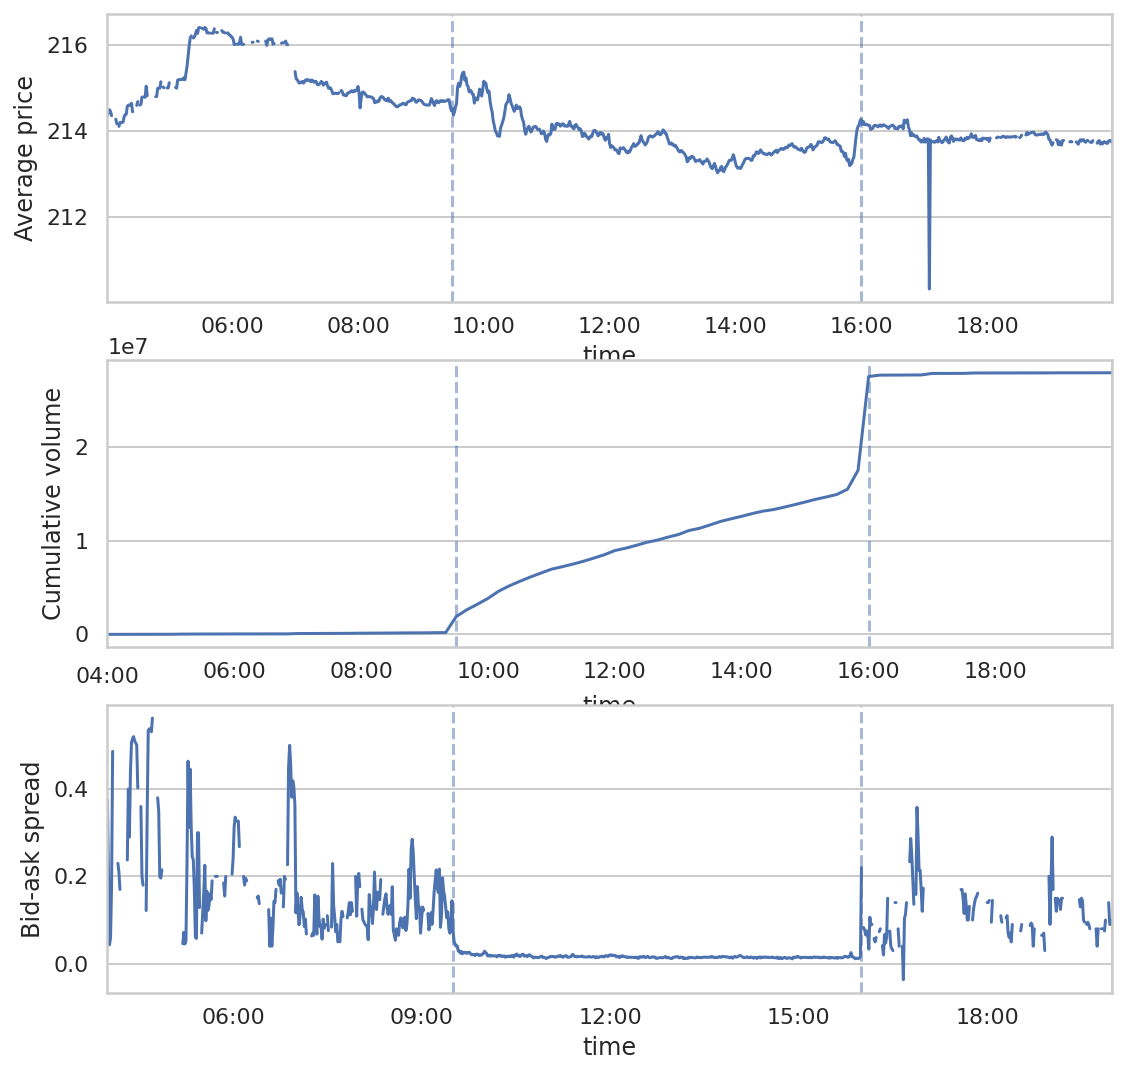

In [62]:
fig, axes = plt.subplots(3, 1, figsize=(9, 9))
trades.groupby(pd.Grouper(key='time', freq='1min'))['price'].mean() \
    .plot.line(ax=axes[0], ylabel='Average price')
trades.groupby(pd.Grouper(key='time', freq='10min'))['volume'].sum().cumsum() \
    .plot.line(ax=axes[1], ylabel='Cumulative volume')
quotes.groupby(pd.Grouper(key='time', freq='1min'))['spread'].mean() \
    .plot.line(ax=axes[2], ylabel='Bid-ask spread')
for ax in axes:
    for time in [(9, 30), (16, 0)]:
        ax.axvline(
            datetime.datetime.combine(date, datetime.time(*time)), 
            linestyle='--', alpha=0.5
        )

The bid-ask spread outside of regular trading hours is ~10 times higher than during, making it riskier to perform transactions outside of trading hours. In addition, most shifts in price happen within hours, making it reasonable to focus on this time. 

### 2. When is a buy profitable?

Average bid-ask spread: 0.027016238675559225


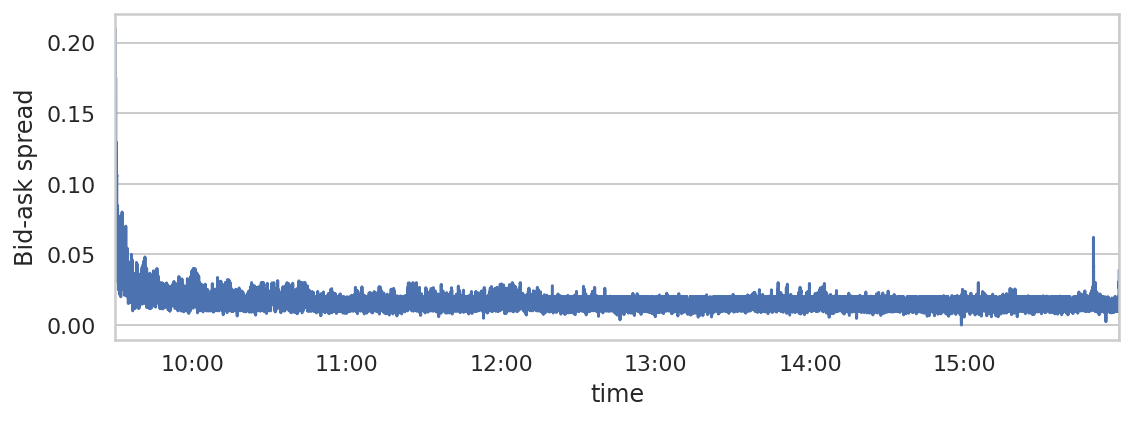

In [112]:
fig, ax = plt.subplots(figsize=(9, 3))
quotes.groupby(pd.Grouper(key='time', freq='1s'))['spread'].mean() \
    .between_time('09:30', '16:00', include_end=False) \
    .plot.line(ax=ax, ylabel='Bid-ask spread')

print('Average bid-ask spread:', price_per_second['spread'].mean())

The average bid-ask spread is less than \\$0.03, meaning that the gain while the stock is owned has to be larger than \\$0.03 for it to be profitable. The exception is during the first minutes after trading starts. For now, that value can be used as a rough threshold, but, optimally, before performing any trade the actual current spread should be checked.

### 3. What time window?

Average trades per second: 8.97371794871795


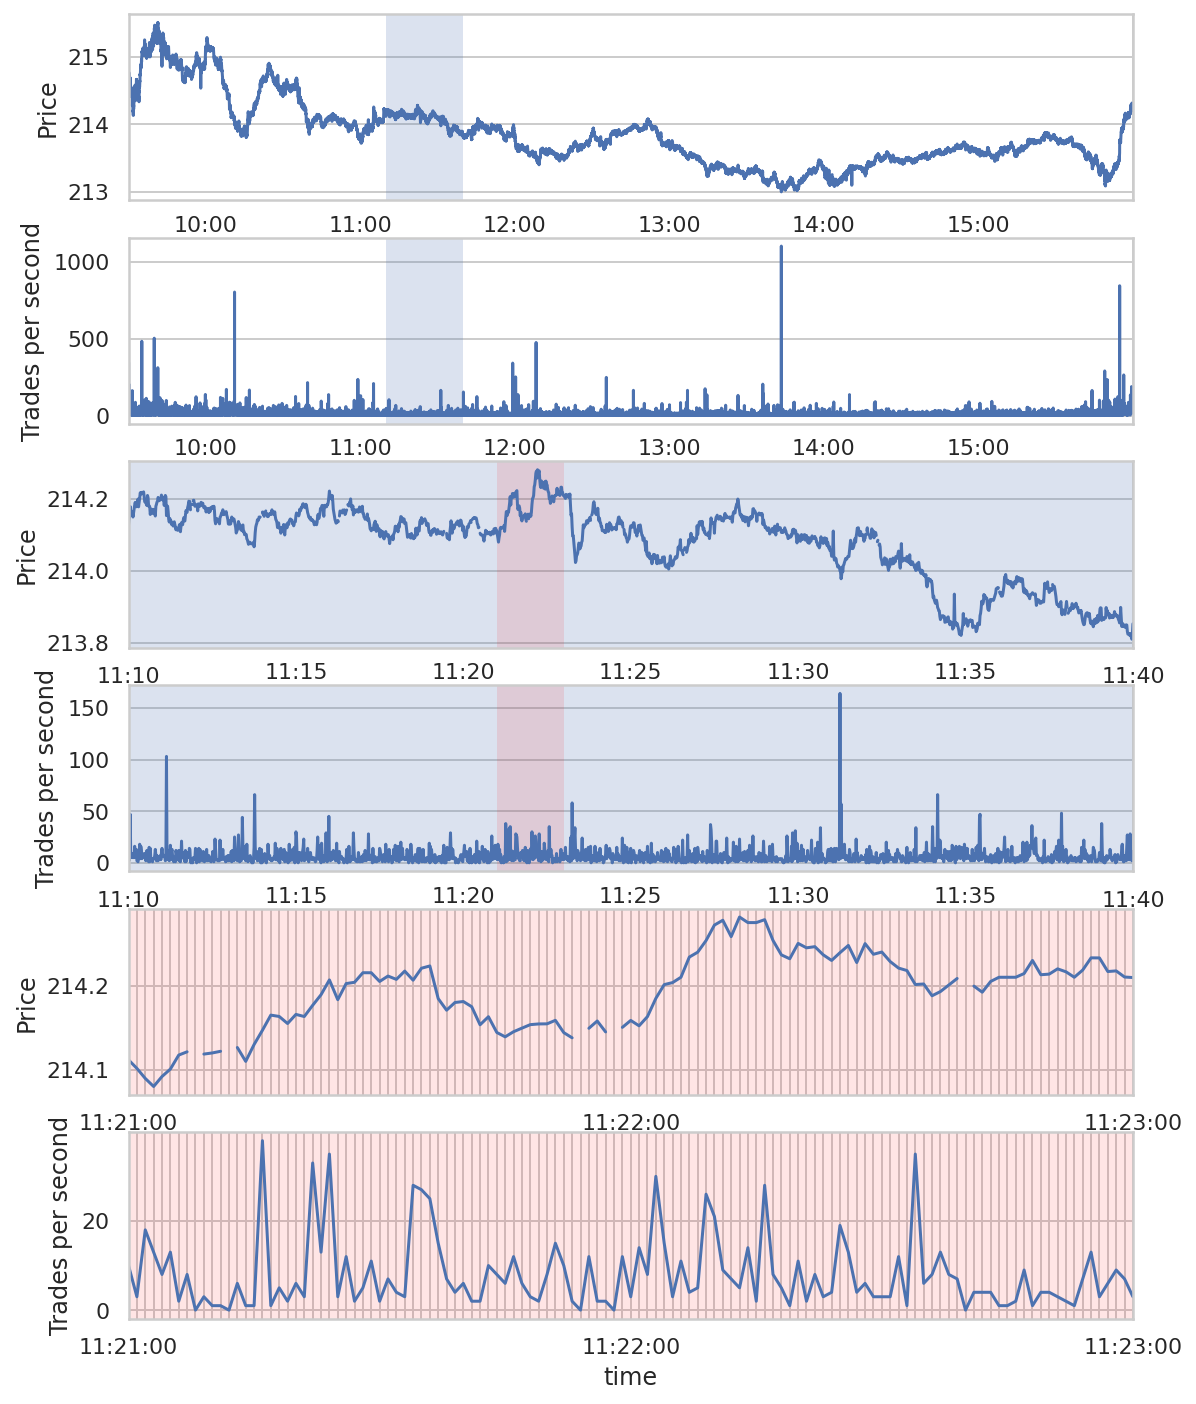

In [191]:
time_window = '1s' #'100ms'
grouper = pd.Grouper(key='time', freq=time_window)
price_per_second = trades.groupby(grouper)['price'].agg(['mean', 'count']) \
    .between_time('9:30', '16:00', include_end=False)

fig, axes = plt.subplots(6, 1, figsize=(9, 12))
price_per_second['mean'].plot.line(ax=axes[0], ylabel='Price')
price_per_second['count'].plot.line(ax=axes[1], ylabel='Trades per second')

subset1 = price_per_second.between_time('10:00', '10:30')
subset1 = price_per_second.between_time('11:10', '11:40')
subset1['mean'].plot.line(ax=axes[2], ylabel='Price')
subset1['count'].plot.line(ax=axes[3], ylabel='Trades per second')
for ax in axes[:4]:
    ax.axvspan(*subset1.index[[0, -1]], alpha=0.2, lw=0)

subset2 = price_per_second.between_time('10:15', '10:17')
subset2 = price_per_second.between_time('11:21', '11:23')
subset2['mean'].plot.line(ax=axes[4], ylabel='Price')
subset2['count'].plot.line(ax=axes[5], ylabel='Trades per second')
for ax in axes[2:]:
    ax.axvspan(*subset2.index[[0, -1]], color='red', alpha=0.1, lw=0)
for ax in axes[4:]:
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=1.0))

print('Average trades per second:', price_per_second['count'].mean())

Prices swings exceeding the spread threshold happen often at the timescale of seconds. Most of the increases above the threshold happens over more than 10 seconds, making it unnecessary to capture nuances at a higher resolution than every second. 

## Feature engineering

Each timepoint should be classified as `buy`, `keep`, or `sell`:

- `buy`: The price is increasing, and it will increase enough to offset the transaction cost. The stock should be bought.
- `sell`: The price is decreasing. The stock should be sold.
- `keep`: The price is neither increasing nor decreasing signficantly. The stock should not bought, but it should also not be sold if it is owned.


For every `n` seconds during open hours, calculate target price and features. For now, `n` is set to `1`. Features are stored back in the database as they can take a while to calculate. 

Feature ideas:

- Summary stats of previous prices and volumes (https://alphascientist.com/feature_engineering.html).
- Trading markers (https://blog.roboforex.com/blog/2020/01/10/creating-a-trading-strategies-based-on-the-mean-reversion-and-momentum/).
- Stats on quotes.
- Relevant news articles.
- Mentions on social networks.


In [ ]:

def stats_per_second(trades, time_from, time_to):
    """ Calculate descriptive stats for trades for every second.
    
    Stats are calculated in the second _before_ the time listed to prevent
    future data leakage.
    
    """
    
    time_period = pd.date_range(time_from, time_to, freq='1S')
    
    grouper = pd.Grouper(key='time', freq='1S')
    trades_grouped = trades.groupby(grouper)
    
    price_stats = trades_grouped['price'].agg(
        ['count', 'mean', 'median', 'min', 'max', 'std']
    )
    price_mean_weighted = weighted_mean(trades, 'price', 'volume', grouper)
    
    volume_stats = trades_grouped['volume'].agg(
        ['sum', 'mean', 'median', 'min', 'max', 'std']
    )
    
    
    stats = pd.DataFrame(index=time_period) \
        .join(price_mean_weighted, how='left') \
        .join(price_stats.add_prefix('price_'), how='left') \
        .join(volume_stats.add_prefix('volume_'), how='left') \
    
    return stats

ticker = 'MSFT'
exchange = db.get_ticker_details(ticker)['exchange']

stored_dates = sorted(db.get_stored_dates('trades', ticker))
open_hours = db.get_open_hours(stored_dates, exchange)

for date in [stored_dates[4], stored_dates[100]]:
    
    trades = db.get_trades(ticker, date)
    print(trades.iloc[0]['time'], trades.iloc[-1]['time'])
    
    open_time, close_time = open_hours[date]
    
    prices = stats_per_second(
        trades, 
        datetime.datetime.combine(date, open_time), 
        datetime.datetime.combine(date, close_time)
    )


#     prices = trades.groupby(period_grouper)['price'].median()
#     # Propegate last valid observation forward.
#     prices = prices.fillna(method='ffill')

prices.iloc[5000:].head(20).fillna(method='ffill')
# prices[prices> 0]

In [ ]:
prices.iloc[5000:].head(20).fillna(method='ffill')

### Target variable
The future price to predict. The variable classified into either `buy`, `don't sell`, or `sell` depending on the relative increase from the current price to the price in `m` seconds. For now, `m` is set to `5`. 

In [ ]:
ticker = 'MSFT'
exchange = db.get_ticker_details(ticker)['exchange']

frequency = '1S' # 1 second

stored_dates = sorted(db.get_stored_dates('trades', ticker))


trades

for date in stored_dates[::-1]:
    
    # Determine open hours (by Robinhood/Alpaca)

    trades = pd.DataFrame(
        db.get_trades(ticker, date), 
        columns=['timestamp', 'price', 'volume']
    )
    trades['time'] = pd.to_datetime(trades['timestamp']) - pd.DateOffset(hours=5) # America/New Yow
    
    price_index = pd.date_range(
        datetime.datetime.combine(date, start_time),
        datetime.datetime.combine(date, close_time),
        freq=frequency,
        closed='left'
    )
    
    prices = pd.DataFrame(index=price_index).merge(
        trades.groupby(pd.Grouper(key='time', freq=frequency))['price'].median(),
        how='left',
        left_index=True,
        right_index=True
    )
    
    # Propegate last valid observation forward.
    prices = prices.fillna(method='ffill')

    break
    
prices

description = 'Price'
db.store_feature(ticker, 'target', prices, description)

### Check features for outliers

### Check feature importance

## Hyperparameter tuning

- Feature time window
- Target variable future time